In [3]:
# Standard Libraries
import os
import time
import warnings
from collections import Counter

# Scientific Computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
)
from sklearn.metrics import (
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score,
    make_scorer
)
from sklearn.exceptions import ConvergenceWarning

# Sklearn - Preprocessing & Imputation
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Sklearn - Models & Feature Selection
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif, SelectKBest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA  # To be removed if not used
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Imbalanced-Learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

# Others
from xgboost import XGBClassifier
from boruta import BorutaPy
from joblib import Parallel, delayed

# Warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data Loading

In [4]:
secom_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
X = pd.read_csv(secom_data_url, sep=' ', header=None)
feature_names = [f'feature{i+1}' for i in range(X.shape[1])]
X.columns = feature_names
X.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
X.shape

(1567, 590)

In [6]:
secom_labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_csv(secom_labels_url, sep=' ', header=None)
label_columns = ['label', 'date_time']
y.columns = label_columns
y['label'] = y['label'].replace(-1, 0)
y.head()

,label,date_time
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


In [7]:
y.shape

(1567, 2)

In [8]:
y['label'].value_counts(normalize=True)

label
0    0.933631
1    0.066369
Name: proportion, dtype: float64

## Train-Test Split and initial analysis

In [9]:
# 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y['label'],
    random_state=42
)

In [10]:
# Check the sizes of the resulting datasets
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 1253, Test set size: 314


In [11]:
# Checking Class Distributions after splitting the data
print('Original label distribution: ')
print(y['label'].value_counts(normalize=True))

print('\nTraining label distribution: ')
print(y_train['label'].value_counts(normalize=True))

print('\nTest label distribution: ')
print(y_test['label'].value_counts(normalize=True))

Original label distribution: 
label
0    0.933631
1    0.066369
Name: proportion, dtype: float64

Training label distribution: 
label
0    0.933759
1    0.066241
Name: proportion, dtype: float64

Test label distribution: 
label
0    0.933121
1    0.066879
Name: proportion, dtype: float64


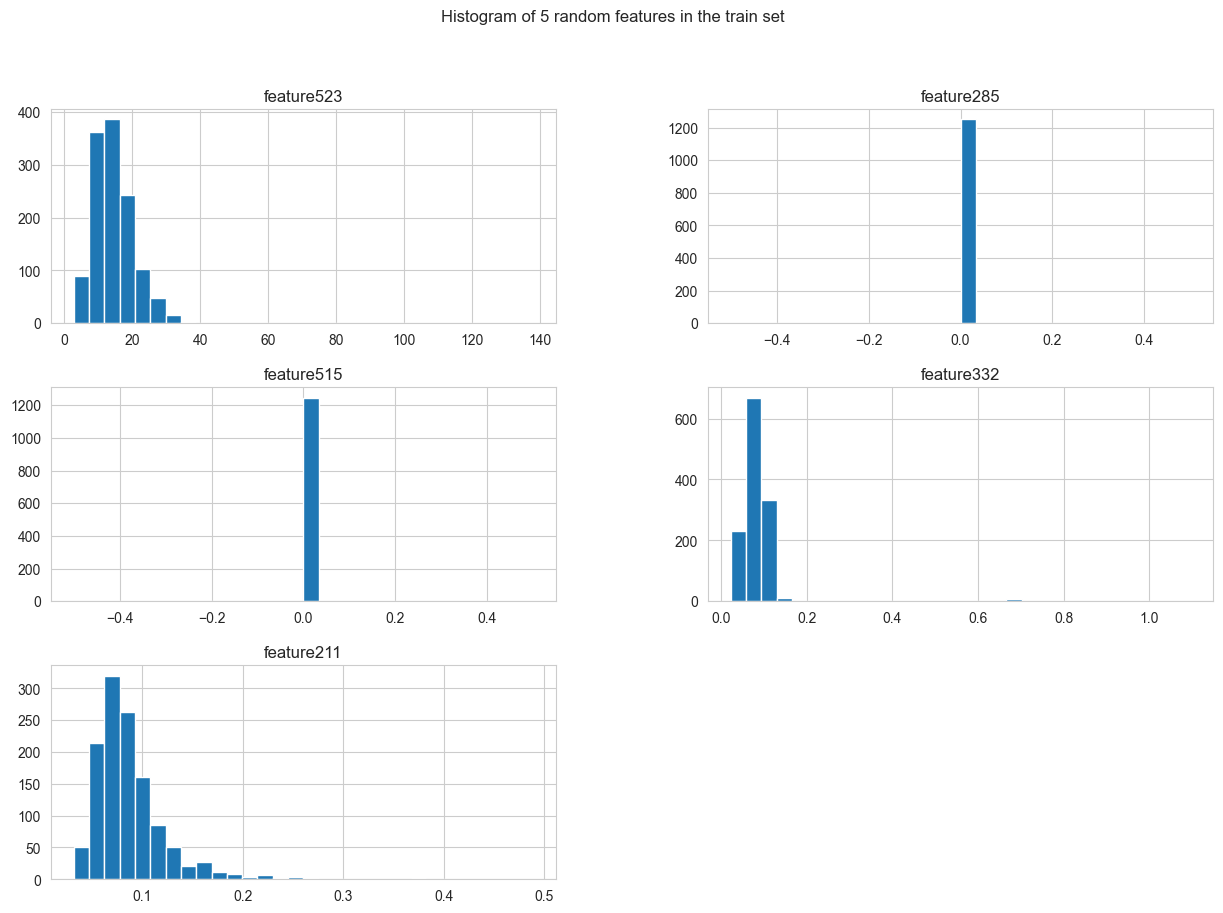

In [12]:
X_train.sample(5, axis=1, random_state=42).hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of 5 random features in the train set')
plt.show()

In [13]:
# Checking for duplicate rows
duplicates = X_train.duplicated()

# Count the number of duplicates
no_of_duplicates = duplicates.sum()
print(f'Number of duplicated rows in X_train: {no_of_duplicates}')

Number of duplicated rows in X_train: 0


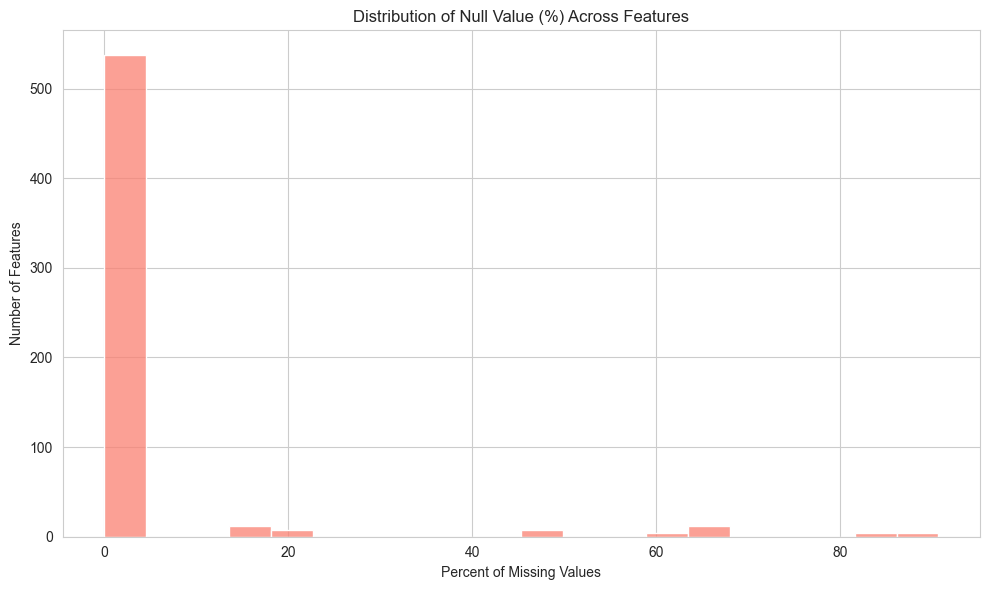

In [14]:
# Distribution of Null Values across features
missing_percent_per_feature = (X_train.isnull().sum() / len(X_train)) * 100

plt.figure(figsize=(10,6))
sns.histplot(missing_percent_per_feature, bins=20, kde=False, color='salmon')
plt.title('Distribution of Null Value (%) Across Features')
plt.xlabel('Percent of Missing Values')
plt.ylabel('Number of Features')
plt.tight_layout()
plt.show()

Based on the viz above we can cleary see a huge jump from around 20% to 45% in the percent of missing value in a feature. Based on this, we've decided to choose our threshold of 45% and features that have this percent of missing values or higher will be removed from the data.

In [15]:
len(missing_percent_per_feature[missing_percent_per_feature > 45])

32

In [16]:
len(X_train.nunique()[X_train.nunique() == 1])

116

There are 32 features that have a high percent of missing values and there are 116 features that have 0 volatility. These features (total of 148 features) will be dropped as they won't offer much info to the training algorithms that will be used

In [17]:
y_train_arr = y_train.drop(columns='date_time')
y_train_arr = y_train_arr.to_numpy().ravel()

## Implementation

## Creating a custom wrapper that preserves the output as a DF. Using it for Imputation methods for now. Can be used elsewhere

In [18]:
class DataFramePreserver(BaseEstimator, TransformerMixin):
  def __init__(self, transformer):
    self.transformer = transformer
    self.columns_ = None
    self.index_ = None

  def fit(self, X, y=None):
    if isinstance(X, pd.DataFrame):
      self.columns_ = X.columns
      self.index_ = X.index
    self.transformer.fit(X, y)
    return self

  def transform(self, X):
    X_t = self.transformer.transform(X)
    return pd.DataFrame(X_t, columns=self.columns_, index=X.index)

## DropHighNullAndConstantFeatures class

In [19]:
class DropHighNullAndConstantFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, null_threshold=0.45):
    self.null_threshold = null_threshold

  def fit(self, X, y=None):
    # Drop columns with high null percentage
    null_ratio_per_feature = X.isnull().mean()
    self.too_null_features_ = null_ratio_per_feature[
        null_ratio_per_feature > self.null_threshold
    ].index.tolist()

    # If a col had all NaNs X[col].nunique() would be 0
    self.constant_features_ = [col for col in X.columns if X[col].nunique() <= 1]

    self.features_to_drop_ = list(
        set(self.too_null_features_ + self.constant_features_)
    )

    return self

  def transform(self, X):
    return X.drop(columns=self.features_to_drop_, errors='ignore')

## Class implementing Outlier Capping

In [20]:
class OutlierCapping(BaseEstimator, TransformerMixin):
  def __init__(self, zscore_threshold=3):
    self.zscore_threshold = zscore_threshold
    self.means_ = None
    self.stds_ = None

  def fit(self, X, y=None):
    X = X.copy()

    # Store the Means and Std. Deviations of all features
    self.means_ = X.mean()
    self.stds_ = X.std()

    return self

  def transform(self, X):
    X = X.copy()

    # Cap outliers using 3σ rule
    for col in X.select_dtypes(include=[np.number]).columns:
      mean = self.means_[col]
      std = self.stds_[col]
      lower = mean - self.zscore_threshold * std
      upper = mean + self.zscore_threshold * std
      X[col] = np.clip(X[col], lower, upper)

    return X

## Class implementing multiple Feature Selection methods

In [21]:
# Feature Selectors
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method='rfe', estimator=None, n_features_to_select=None, fraction_to_select=0.1, n_estimators=1000, max_iter=500):
        self.method = method
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.fraction_to_select = fraction_to_select
        self.n_estimators = n_estimators
        self.max_iter = max_iter

    def fit(self, X, y):
        # print("[FeatureSelector] fit called.")
        X = np.array(X)
        
        if self.method == 'rfe':
            if self.estimator is None:
                self.estimator = RandomForestClassifier(
                    n_estimators=1000, min_samples_leaf=5,
                    class_weight='balanced_subsample', max_depth=None,
                    n_jobs=-1, random_state=42
                )

            # Calculate features to select if not provided
            if self.n_features_to_select is None:
                self.n_features_to_select = int(X.shape[1] * self.fraction_to_select)
            
            self.selector_ = RFE(estimator=clone(self.estimator), n_features_to_select=self.n_features_to_select)
            
        elif self.method == 'lasso':
            # For Lasso, class weighting isn't relevant (it's regression), 
            # but you could replace Lasso with LogisticRegression(penalty='l1', solver='liblinear') if you want class-aware linear selection.
            self.selector_ = SelectFromModel(Lasso(alpha=0.01, random_state=42))
            
        elif self.method == 'boruta':
            # Using BorutaPy for feature selection
            if self.estimator is None:
                self.estimator = RandomForestClassifier(
                    n_estimators=1000, min_samples_leaf=5,
                    class_weight='balanced_subsample', max_depth=None,
                    n_jobs=-1, random_state=42
                )
                
            self.selector_ = BorutaPy(
                estimator=clone(self.estimator),
                n_estimators='auto',
                perc=80,
                random_state=42,
            )
        else:
            raise ValueError("Unsupported method. Use 'rfe', 'lasso' or 'boruta'.")
            
        self.selector_.fit(X, y)
        # print("[FeatureSelector] fit complete.")
        return self

    def transform(self, X):
        # print("[FeatureSelector] transform called.")
        if not hasattr(self, 'selector_'):
            raise RuntimeError("You must fit the transformer before calling transform.")
        return self.selector_.transform(np.array(X))

    def get_support(self):
        if not hasattr(self, 'selector_'):
            raise RuntimeError("fit() must be called before get_support().")

        # For Boruta, useing support_ attribute directly
        if self.method == 'boruta':
            return self.selector_.support_

        # For RFE and Lasso, using get_support() method
        return self.selector_.get_support()

In [ ]:
# class AutoencoderDimReducer(BaseEstimator, TransformerMixin):
#   def __init__(self, encoding_dim=20, epochs=50, batch_size=32, verbose=0):
#     self.encoding_dim = encoding_dim
#     self.epochs = epochs
#     self.batch_size = batch_size
#     self.verbose = verbose

#   def build_model(self, input_dim):
#     input_layer = Input(shape=(input_dim,))
#     encoded = Dense(128, activation='relu')(input_layer)
#     encoded = Dense(64, activation='relu')(encoded)
#     bottleneck = Dense(self.encoding_dim, activation='relu')(encoded)
#     decoded = Dense(64, activation='relu')(bottleneck)
#     decoded = Dense(128, activation='relu')(decoded)
#     output_layer = Dense(input_dim, activation='linear')(decoded)

#     autoencoder = Model(inputs=input_layer, outputs=output_layer)
#     encoder = Model(inputs=input_layer, outputs=bottleneck)

#     autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     return autoencoder, encoder

#   def fit(self, X, y=None):
#     X = np.array(X).astype(np.float32)
#     self.input_dim_ = X.shape[1]
#     self.autoencoder_, self.encoder_ = self.build_model(self.input_dim_)

#     es = EarlyStopping(patience=5, restore_best_weights=True)
#     self.autoencoder_.fit(
#         X, X,
#         epochs=self.epochs,
#         batch_size=self.batch_size,
#         shuffle=True,
#         validation_split=0.1,
#         callbacks=[es],
#         verbose=self.verbose
#     )

#     return self

#   def transform(self, X):
#     X = np.array(X).astype(np.float32)
#     return self.encoder_.predict(X)

#   def fit_transform(self, X, y=None):
#     self.fit(X, y)
#     return self.transform(X)

## Display class distributions after balancing

In [22]:
class DebugTargetStats(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    if y is not None:
      counts = np.bincount(y)
      print(f"[Debug] Class distribution after balancing: Negative={counts[0]}, Positive={counts[1]}")
    return self

  def transform(self, X):
    return X

In [2]:
##If you want to skip adding a component within the pipeline

In [23]:
class NoOperation(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X

## Function to create our imbalanced pipeline and set the steps

In [24]:
def create_pipeline(imp_name, imputer, fs_name, selector, bal_name, balancer,
                    dim_red_name, dim_reducer, model, apply_scaling = False):
  steps = []

  steps.append(('preprocess', DropHighNullAndConstantFeatures()))

  steps.append(('impute', DataFramePreserver(imputer)))

  steps.append(('cap', OutlierCapping()))
  
  if apply_scaling:
    steps.append(('scale', DataFramePreserver(RobustScaler())))
      
  steps.append(('select', selector))

  steps.append(('balance', balancer))

  debug_step = DebugTargetStats() if bal_name != 'none' else NoOperation()
  steps.append(('debug', debug_step))

  #steps.append(('balance', balancer))
  steps.append(('dim_redn', dim_reducer))

  steps.append(('clf', model))

  print("\nFinal Pipeline steps:")
  for name, step in steps:
    print(f" - {name}: {step}")

  return ImbPipeline(steps)

## Pipeline Components

In [25]:
# Since XGB doesn't have class_weight='balanced', we need to define one that can be used
custom_class_weight = float(y_train['label'].value_counts()[0] / y_train['label'].value_counts()[1])

# Define pipeline components
imputers = {
    "none": lambda: NoOperation(),
    "median": lambda: SimpleImputer(strategy="median"),
    "knn": lambda: KNNImputer(n_neighbors=5),
    "mice": lambda: IterativeImputer(random_state=42)
}

feature_selectors = {
    "none": lambda: NoOperation(),
    "rfe": lambda: FeatureSelector(method='rfe'),
    "lasso": lambda: FeatureSelector(method='lasso'),
    "boruta": lambda: FeatureSelector(method='boruta'),
    "boruta2": lambda: FeatureSelector(
        method='boruta',
        post_prune_method='selectkbest',
        post_prune_k=100,
        verbose=True
    ),
    "boruta3": lambda: FeatureSelector(
        method='boruta',
        post_prune_method='selectfrommodel',
        verbose=True
    )
}

balancers = {
    "none": lambda: NoOperation(),
    "SMOTE3": lambda: SMOTE(k_neighbors=3, random_state=42),
    "smote": lambda: SMOTE(random_state=42),
    "adasyn": lambda: ADASYN(random_state=42),
    "rose": lambda: RandomOverSampler(random_state=42)
}

dim_reducers = {
    "none": lambda: NoOperation(),
    "lda": lambda: LinearDiscriminantAnalysis(),
    "pca30": lambda: PCA(n_components=30, random_state=42),
    "pca50": lambda: PCA(n_components=50, random_state=42),
    # "autoencoder20": lambda: AutoencoderDimReducer(encoding_dim=20, epochs=50, verbose=0),
    # "autoencoder30": lambda: AutoencoderDimReducer(encoding_dim=30, epochs=50, verbose=0),
    # "autoencoder40": lambda: AutoencoderDimReducer(encoding_dim=40, epochs=50, verbose=0),
}

models = {
    "none": lambda: NoOperation(),
    "RandomForest": lambda: RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "LogisticRegression": lambda: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1),
    "SVC": lambda: SVC(probability=True, class_weight='balanced', random_state=42), # try LinearSVC or use SVC with some kernel like rbf, rbf is default btw
    "XGB": lambda: XGBClassifier(
        max_depth=6, n_estimators=300, subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=custom_class_weight, learning_rate=0.1,
        eval_metric='logloss', random_state=42, n_jobs=-1
        ),
    "CalibratedRF": lambda: CalibratedClassifierCV(
        estimator=RandomForestClassifier(
            n_estimators=300, max_depth=15,
            min_samples_leaf=3, class_weight='balanced',
            random_state=42, n_jobs=-1
        ),
        method='isotonic',
        cv=3
      )
}

## Experimentation

In [26]:
def log_results(new_results, path="experiment_results.csv"):
  # If the file exists, load it
  if os.path.exists(path):
    existing_df = pd.read_csv(path)
    combined_df = pd.concat([existing_df, pd.DataFrame(new_results)], ignore_index=True)
  else:
    combined_df = pd.DataFrame(new_results)

  combined_df.to_csv(path, index=False)
  print(f"Logged {len(new_results)} results to {path}")

In [78]:
models.keys()

dict_keys(['none', 'RandomForest', 'LogisticRegression', 'SVC', 'XGB', 'CalibratedRF'])

In [27]:

results = []

test_mode = True

if test_mode:
  test_combinations = [
      ('knn',	'boruta',	'rose',	'none',	'XGB',	True),
      ('knn',	'boruta',	'smote',	'none',	'RandomForest',	True)
  ]

else:
  test_combinations = [
    (imp, fs, bal, dr, model, apply_scaling)
    for imp in imputers
    for fs in feature_selectors
    for bal in balancers
    for dr in dim_reducers
    for model in models
    for apply_scaling in (False, True)
  ]

for imp_name, fs_name, bal_name, dim_red_name, model_name, apply_scaling in test_combinations:
  # Fresh components for each fold
  imputer = imputers[imp_name]()
  selector = feature_selectors[fs_name]()
  balancer = balancers[bal_name]()
  dim_reducer = dim_reducers[dim_red_name]()
  model = models[model_name]()
  apply_scaling = apply_scaling
  try:
    # Define the pipeline name for logging
    name = f"{imp_name}_{bal_name}_{fs_name}_{dim_red_name}_{model_name}_{apply_scaling}"
    print(f"\nTraining {name}...")

    start_time = time.time()

    # pipe = create_pipeline(imp_name, imputer, fs_name, selector,
    #                        bal_name, balancer, dim_red_name, dim_reducer,
    #                        model, apply_scaling)

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

   
    # Hybrid approach to get feature counts
    feature_counts=[]
    for train_idx, val_idx in cv.split(X_train, y_train_arr):
        X_tr, y_tr = X_train.iloc[train_idx], y_train_arr[train_idx]
        print("Train Valid split done")

        # Use pipeline with "none" model for feature selection only
        pipe = create_pipeline(imp_name, imputer, fs_name, selector,
                           bal_name, balancer, dim_red_name, dim_reducer,
                           models["none"](), apply_scaling)

        pipe.fit(X_tr, y_tr)

        n_features = pipe.named_steps['select'].get_support().sum()
        feature_counts.append(n_features)
    
    # Measure execution time
    execution_time = round(time.time() - start_time, 2)
    
    results.append({
      'Pipeline': name,
      # 'Best Threshold': round(best_threshold, 4),
      # 'F1': round(best_f1, 4),
      # 'Precision': round(best_precision, 4),
      # 'Recall': round(best_recall, 4),
      # 'ROC-AUC': round(roc_auc, 4),
      'Mean of Features Selected': round(np.mean(feature_counts), 2),
      'Std of Features Selected': round(np.std(feature_counts), 2),
      'Execution Time (s)': execution_time
    })

  except Exception as e:
    print(f"Pipeline {name} failed: {e}")


Training knn_rose_boruta_none_XGB_True...
Train Valid split done

Final Pipeline steps:
 - preprocess: DropHighNullAndConstantFeatures()
 - impute: DataFramePreserver(transformer=KNNImputer())
 - cap: OutlierCapping()
 - scale: DataFramePreserver(transformer=RobustScaler())
 - select: FeatureSelector(method='boruta')
 - balance: RandomOverSampler(random_state=42)
 - debug: DebugTargetStats()
 - dim_redn: NoOperation()
 - clf: NoOperation()
[Debug] Class distribution after balancing: Negative=936, Positive=936
Train Valid split done

Final Pipeline steps:
 - preprocess: DropHighNullAndConstantFeatures()
 - impute: DataFramePreserver(transformer=KNNImputer())
 - cap: OutlierCapping()
 - scale: DataFramePreserver(transformer=RobustScaler())
 - select: FeatureSelector(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                 min_samples_leaf=5,
                                                 n_estimators=1000, n_jobs=-1,
        

In [ ]:

from sklearn.model_selection import GridSearchCV

# Example pipeline
pipe = create_pipeline(
    imputer=KNNImputer(),
    selector=FeatureSelector(method='boruta'),
    balancer=SMOTE(),
    model=RandomForestClassifier(class_weight='balanced', random_state=42),
    apply_scaling=True
)

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'impute__n_neighbors': [3, 5, 7],
    'clf__max_depth': [10, 20]
}

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train['label'])

# Print best results
print("Best parameters:", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


In [81]:
results

[{'Pipeline': 'knn_smote_boruta_none_XGB_True',
  'Best Threshold': 0.2613,
  'F1': 0.2617,
  'Precision': 0.2137,
  'Recall': 0.3373,
  'ROC-AUC': 0.678,
  'Mean of Features Selected': 69.4,
  'Std of Features Selected': 10.518555033843764,
  'Execution Time (s)': 392.84}]

In [82]:
log_results(results)

Logged 1 results to experiment_results.csv


In [120]:
results

[{'Pipeline': 'mice_smote_none_none_RandomForest_True',
  'Best Threshold': np.float64(0.29),
  'F1': np.float64(0.2415),
  'Precision': np.float64(0.2016),
  'Recall': np.float64(0.3012),
  'ROC-AUC': np.float64(0.7145),
  'Num Features Selected': 'unknown',
  'Execution Time (s)': 748.0}]

In [ ]:
# Sample subset of data
X_fold = X_train.iloc[:1000].copy()
y_fold = y_train_arr[:1000].copy()

# 1. Drop high-null and constant features (simulate your pipeline)
null_thresh = 0.45
high_null_cols = X_fold.columns[X_fold.isnull().mean() > null_thresh]
constant_cols = [col for col in X_fold.columns if X_fold[col].nunique(dropna=True) <= 1]
drop_cols = set(high_null_cols).union(constant_cols)
X_fold.drop(columns=drop_cols, inplace=True)

# 2. Impute missing values (KNN or median)
imputer = KNNImputer(n_neighbors=5)
X_fold_imputed = pd.DataFrame(imputer.fit_transform(X_fold), columns=X_fold.columns)

# 3. Now apply your FeatureSelector
selector = FeatureSelector(
    method='boruta',
    post_prune_method='selectkbest',
    post_prune_k=100,
    verbose=True
)

# Fit and transform
selector.fit(X_fold_imputed, y_fold)
X_transformed = selector.transform(X_fold_imputed)

print(f"Final shape after selection: {X_transformed.shape}")

[FeatureSelector] 56 features selected with 'boruta'.
Final shape after selection: (1000, 56)
